# 3.4 Disaster Project
The goal of this project is to classify tweets as relating to a disaster or not, using the [linked](https://www.kaggle.com/competitions/nlp-getting-started/overview) Kaggle dataset. This project will use NLP (Natural Language Processing) to read and interpret the data. I will be make several Recurrent Neural Networks (RNNs), which are types of Neural Networks that feed information back to previous states to inform current ones, making them powerful in interpreting text. More information on RNN Models can be found at tensorflow at [this link](https://www.tensorflow.org/guide/keras/working_with_rnns). I used the following model types in my experiments: 

- LSTM_64
- LSTM_128
- GRU_64
- BiLSTM_64
- BiGRU_64

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Load data (paths assume Kaggle-style layout or local copies)
train = pd.read_csv("data\\train.csv")
test = pd.read_csv("data\\test.csv")
sample_submission = pd.read_csv("data\\sample_submission.csv")

train.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 1: EDA

In [29]:
print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("\nTrain columns:", train.columns.tolist())

print("\n=== Train info() ===")
print(train.info())

print("\n=== Missing values in train ===")
print(train.isnull().sum())


Train shape: (7613, 5)
Test shape : (3263, 4)

Train columns: ['id', 'keyword', 'location', 'text', 'target']

=== Train info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

=== Missing values in train ===
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Target value counts:
target
0    4342
1    3271
Name: count, dtype: int64


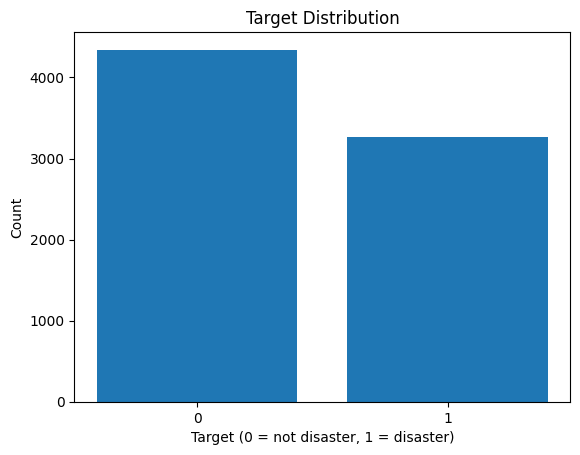


Text length (characters) summary:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_len, dtype: float64


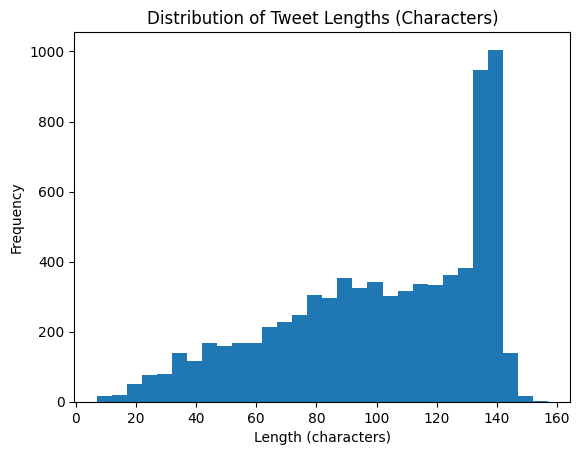


Word count summary:
count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64


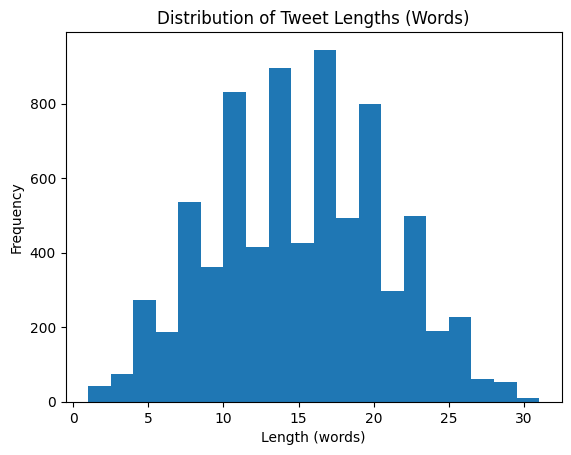

In [30]:
# Target distribution
target_counts = train["target"].value_counts()
print("Target value counts:")
print(target_counts)

plt.figure()
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title("Target Distribution")
plt.xlabel("Target (0 = not disaster, 1 = disaster)")
plt.ylabel("Count")
plt.show()

# Text length (characters)
train["text_len"] = train["text"].str.len()
print("\nText length (characters) summary:")
print(train["text_len"].describe())

plt.figure()
plt.hist(train["text_len"], bins=30)
plt.title("Distribution of Tweet Lengths (Characters)")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")
plt.show()

# Text length (words
train["word_count"] = train["text"].str.split().apply(len)
print("\nWord count summary:")
print(train["word_count"].describe())

plt.figure()
plt.hist(train["word_count"], bins=20)
plt.title("Distribution of Tweet Lengths (Words)")
plt.xlabel("Length (words)")
plt.ylabel("Frequency")
plt.show()


## Data Cleaning

In [31]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # Remove @mentions
    text = re.sub(r"@\w+", " ", text)
    # Remove hashtags (keep the word, drop '#')
    text = re.sub(r"#", " ", text)
    # Remove HTML entities like &amp;
    text = re.sub(r"&\w+;", " ", text)

    # Remove digits
    text = re.sub(r"\d+", " ", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)

train[["text", "clean_text"]].head()


,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfires evacuation orders in ...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


In [36]:
# Hyperparameters for tokenization / sequences
MAX_WORDS = 2000
MAX_LEN = 30

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(pd.concat([train["clean_text"], test["clean_text"]]))

X_seq = tokenizer.texts_to_sequences(train["clean_text"])
X_test_seq = tokenizer.texts_to_sequences(test["clean_text"])

X = pad_sequences(X_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

y = train["target"].values

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Val size  :", X_val.shape[0])



X shape: (7613, 30)
X_test shape: (3263, 30)
Train size: 6090
Val size  : 1523


# 3: Analysis

In [ ]:
def build_rnn_model(
    vocab_size=MAX_WORDS,
    max_len=MAX_LEN,
    embedding_dim=100,
    rnn_type="LSTM",
    units=64,
    bidirectional=False,
    dropout_rate=0.5
):
    """
    Build a simple RNN-based classifier
    """
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

    if rnn_type.upper() == "LSTM":
        rnn_layer = LSTM(units, dropout=dropout_rate, recurrent_dropout=0.0)
    else:
        rnn_layer = GRU(units, dropout=dropout_rate, recurrent_dropout=0.0)

    if bidirectional:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)

    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model


In [38]:
baseline_model = build_rnn_model(
    rnn_type="LSTM",
    units=64,
    bidirectional=False,
    dropout_rate=0.5
)

baseline_model.summary()

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history_baseline = baseline_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


c:\Users\user1\Documents\Masters\deeplearning\3.4\Disaster-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5675 - loss: 0.6863 - val_accuracy: 0.5706 - val_loss: 0.6821
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7103 - loss: 0.5554 - val_accuracy: 0.7965 - val_loss: 0.4544
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8220 - loss: 0.4234 - val_accuracy: 0.8063 - val_loss: 0.4397
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8392 - loss: 0.3836 - val_accuracy: 0.8155 - val_loss: 0.4308
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8545 - loss: 0.3572 - val_accuracy: 0.8194 - val_loss: 0.4390
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8642 - loss: 0.3342 - val_accuracy: 0.8083 - val_loss: 0.4628
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8718 - loss: 0.3157 - val_accuracy: 0.8037 - val_loss: 0.4713
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


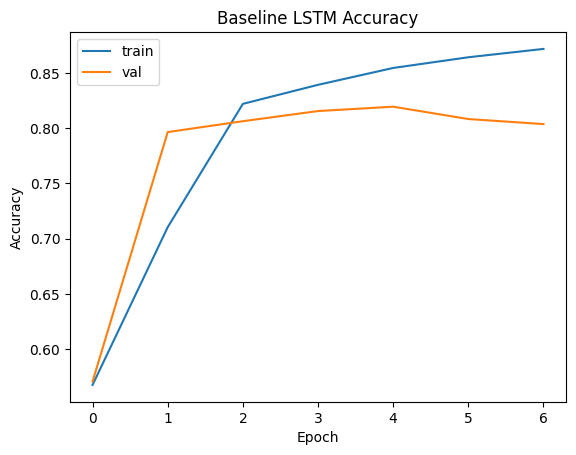

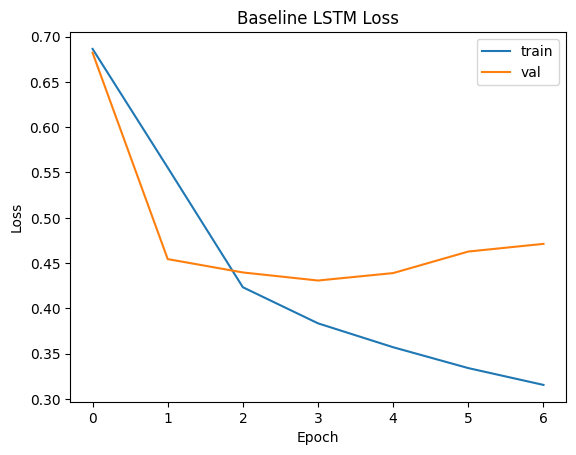

In [39]:
def plot_history(history, title_prefix="Model"):
    # Accuracy
    plt.figure()
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Loss
    plt.figure()
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history_baseline, title_prefix="Baseline LSTM")


In [ ]:
# Evaluate on validation set
val_preds_proba = baseline_model.predict(X_val)
val_preds = (val_preds_proba >= 0.5).astype(int).ravel()

print("Baseline LSTM – Classification Report")
print(classification_report(y_val, val_preds, digits=3))

print("Confusion Matrix")
print(confusion_matrix(y_val, val_preds))


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
=== Baseline LSTM – Classification Report ===
              precision    recall  f1-score   support

           0      0.785     0.931     0.852       869
           1      0.878     0.662     0.755       654

    accuracy                          0.815      1523
   macro avg      0.832     0.797     0.804      1523
weighted avg      0.825     0.815     0.810      1523

=== Confusion Matrix ===
[[809  60]
 [221 433]]


## Different Models
In this part, I created a list of different models to cycle through. In the following for-loop, I run through five different model variants: two LSTM models, a GRU model, BiLSTM, and BiGRU.

In [ ]:
experiments = [
    {"name": "LSTM_64", "rnn_type": "LSTM", "units": 64, "bidirectional": False, "dropout": 0.5},
    {"name": "LSTM_128", "rnn_type": "LSTM", "units": 128, "bidirectional": False, "dropout": 0.5},
    {"name": "GRU_64", "rnn_type": "GRU", "units": 64, "bidirectional": False, "dropout": 0.5},
    {"name": "BiLSTM_64", "rnn_type": "LSTM", "units": 64, "bidirectional": True, "dropout": 0.5},
    {"name": "BiGRU_64", "rnn_type": "GRU", "units": 64, "bidirectional": True, "dropout": 0.5},
]

results = []

for exp in experiments:
    print(f"\n\nTraining experiment: {exp['name']}")
    model = build_rnn_model(
        rnn_type=exp["rnn_type"],
        units=exp["units"],
        bidirectional=exp["bidirectional"],
        dropout_rate=exp["dropout"]
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )

    best_val_acc = max(history.history["val_accuracy"])
    best_val_loss = min(history.history["val_loss"])

    val_preds_proba = model.predict(X_val)
    val_preds = (val_preds_proba >= 0.5).astype(int).ravel()

    report = classification_report(y_val, val_preds, output_dict=True)
    f1 = report["weighted avg"]["f1-score"]

    results.append({
        "model": exp["name"],
        "rnn_type": exp["rnn_type"],
        "units": exp["units"],
        "bidirectional": exp["bidirectional"],
        "dropout": exp["dropout"],
        "best_val_acc": best_val_acc,
        "best_val_loss": best_val_loss,
        "val_f1_weighted": f1
    })

results_df = pd.DataFrame(results).sort_values(by="val_f1_weighted", ascending=False)
results_df




=== Training experiment: LSTM_64 ===


c:\Users\user1\Documents\Masters\deeplearning\3.4\Disaster-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


=== Training experiment: LSTM_128 ===


c:\Users\user1\Documents\Masters\deeplearning\3.4\Disaster-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


=== Training experiment: GRU_64 ===


c:\Users\user1\Documents\Masters\deeplearning\3.4\Disaster-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 6.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


=== Training experiment: BiLSTM_64 ===


c:\Users\user1\Documents\Masters\deeplearning\3.4\Disaster-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


=== Training experiment: BiGRU_64 ===


c:\Users\user1\Documents\Masters\deeplearning\3.4\Disaster-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


,model,rnn_type,units,bidirectional,dropout,best_val_acc,best_val_loss,val_f1_weighted
2,GRU_64,GRU,64,False,0.5,0.820092,0.416657,0.816264
0,LSTM_64,LSTM,64,False,0.5,0.816152,0.430651,0.815463
3,BiLSTM_64,LSTM,64,True,0.5,0.816809,0.439125,0.815206
4,BiGRU_64,GRU,64,True,0.5,0.813526,0.434035,0.810663
1,LSTM_128,LSTM,128,False,0.5,0.811556,0.437249,0.804088


       model rnn_type  units  bidirectional  dropout  best_val_acc  \
0     GRU_64      GRU     64          False      0.5      0.820092   
1    LSTM_64     LSTM     64          False      0.5      0.816152   
2  BiLSTM_64     LSTM     64           True      0.5      0.816809   
3   BiGRU_64      GRU     64           True      0.5      0.813526   
4   LSTM_128     LSTM    128          False      0.5      0.811556   

   best_val_loss  val_f1_weighted  
0       0.416657         0.816264  
1       0.430651         0.815463  
2       0.439125         0.815206  
3       0.434035         0.810663  
4       0.437249         0.804088  


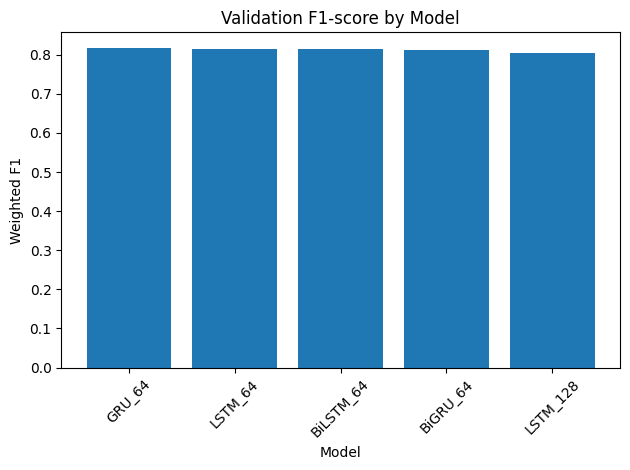

In [42]:
results_df = results_df.reset_index(drop=True)
print(results_df)

plt.figure()
plt.bar(results_df["model"], results_df["val_f1_weighted"])
plt.title("Validation F1-score by Model")
plt.xlabel("Model")
plt.ylabel("Weighted F1")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Results & Analysis

LSTM_64 was the most accurate model, though they are all close in accuracy.

In [43]:
# Choose the best model (by val_f1_weighted)
best_row = results_df.iloc[0]
print("Best configuration:")
print(best_row)

best_model = build_rnn_model(
    rnn_type=best_row["rnn_type"],
    units=int(best_row["units"]),
    bidirectional=bool(best_row["bidirectional"]),
    dropout_rate=float(best_row["dropout"])
)

early_stop_full = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)




Best configuration:
model                GRU_64
rnn_type                GRU
units                    64
bidirectional         False
dropout                 0.5
best_val_acc       0.820092
best_val_loss      0.416657
val_f1_weighted    0.816264
Name: 0, dtype: object


c:\Users\user1\Documents\Masters\deeplearning\3.4\Disaster-Project\env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
test_preds_proba = best_model.predict(X_test)
test_preds = (test_preds_proba >= 0.5).astype(int).ravel()

submission = pd.DataFrame({
    "id": test["id"],
    "target": test_preds
})

submission.to_csv("submission.csv", index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# Conclusion
The most successful model I used was the GRU Model, a type of RNN Model. It had an accuracy of 0.82. I would like to try to make different types of models on this data, including supervised models to compare the accuracy to.